<a href="https://colab.research.google.com/github/sxergiu/fac-year-3/blob/main/IPR/IPR_Laboratory_Test_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

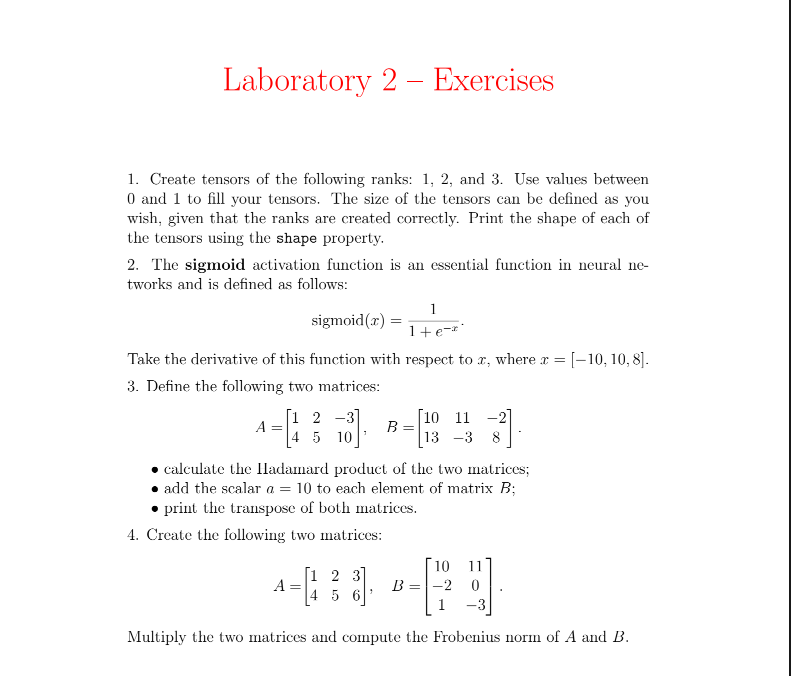

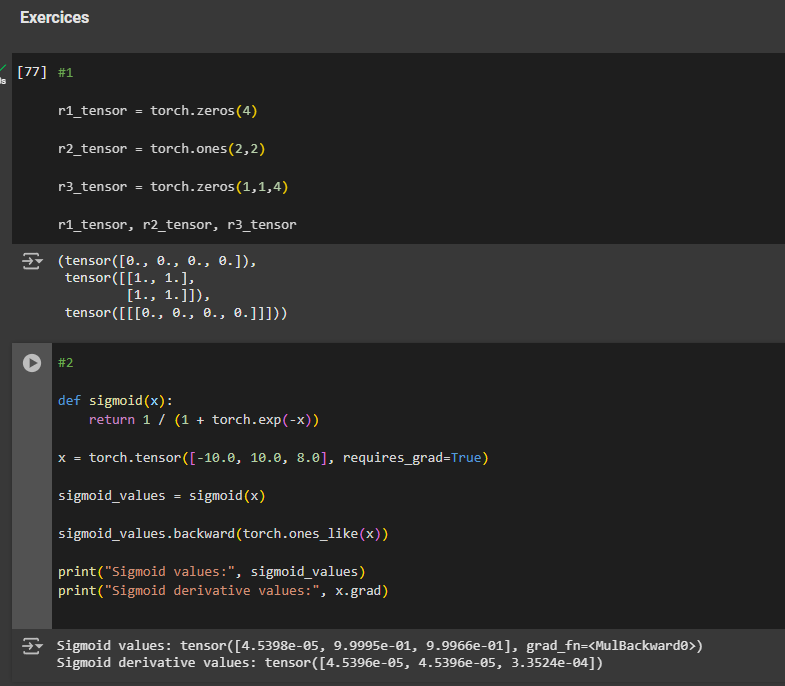

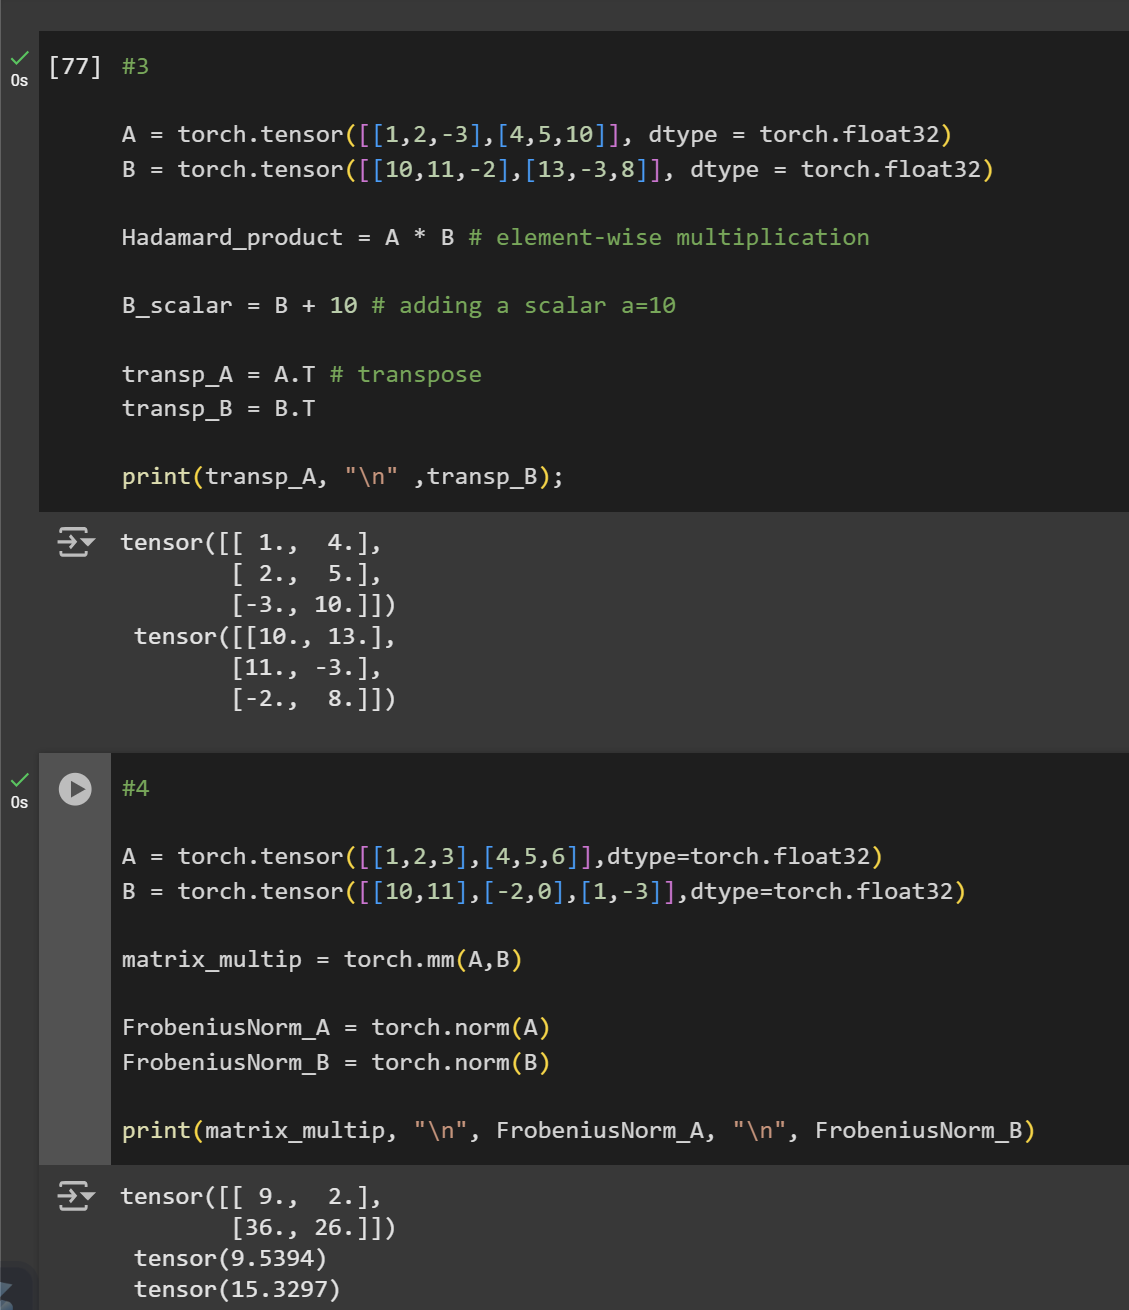

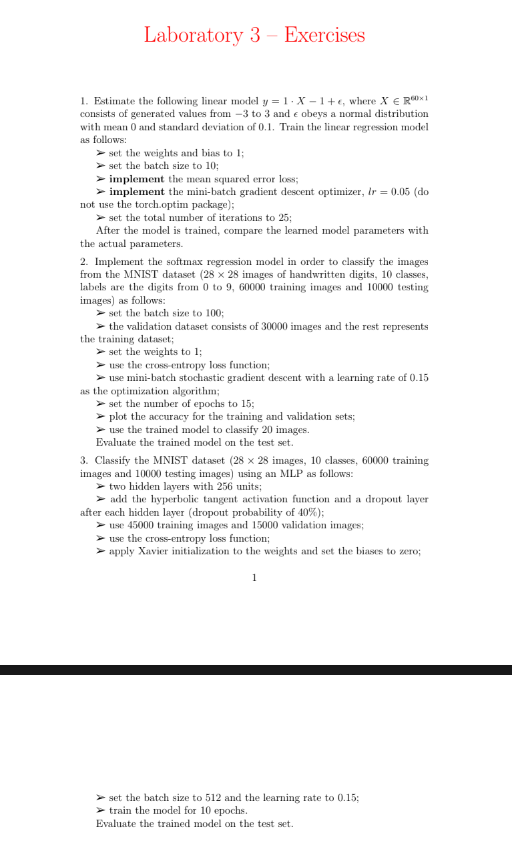



**Linear Regression**

In [ ]:
# Useful code

# data definition
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = X @ w + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape(-1, 1)

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)


# data iteration
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

# efficient pytorch api iteration
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

# defining a network
net = nn.Sequential(nn.Linear(2, 1))

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

loss = nn.MSELoss()

optimizer = torch.optim.SGD(net.parameters(), lr=0.03)

# training loop example
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    l = loss(net(features), labels)
    print(f'Epoch {epoch + 1}, Loss {l:f}')

# comparing ground truth with predictions
w = net[0].weight.data
print('Error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('Error in estimating b:', true_b - b)

# explicit loss
def mse_loss( y_prediction, y_true ):
  return (y_prediction - y_true).pow(2).mean()


In [ ]:
# 1
import torch
import numpy as np
from torch import nn

torch.manual_seed(0) # init
np.random.seed(0)

# linear model
X = torch.unsqueeze(torch.linspace(-3,3,60), dim=1)
epsilon = torch.normal(0,0.1,X.size()) # noise
y = 1 * X - 1 + epsilon

# nn model
model = nn.Sequential(nn.Linear(1, 1))

with torch.no_grad():
    model[0].weight.fill_(1.0) # weights
    model[0].bias.fill_(1.0) # bias

# hyperparams
batch_size = 10
lr = 0.05
iterations = 25

# loss
loss_func = nn.MSELoss()

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

def training_loop(iterations):

  for epoch in range(iterations):
    for X_batch, y_batch in data_iter(batch_size, X, y):

      y_prediction = model(X_batch)
      loss = loss_func(net(X),y)
      loss.backward()

      # no torch.optim package
      with torch.no_grad():
        for param in model[0].parameters():
          param -= lr * param.grad
          param.grad.zero_() # reset gradients

      with torch.no_grad():
        total_loss = loss_func(model(features), labels)
        print(f'Epoch {epoch + 1}, Loss {total_loss:f}')

print("Learned weight:", model[0].weight.data)
print("Learned bias:", model[0].bias.data)
print("Actual weight: 1.0, Actual bias: -1.0")



**Working with FashionMNIST**

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torchvision
from torchvision import transforms

In [ ]:

# `ToTensor()` converts the image data from PIL type to 32-bit floating point
# tensors. It also divides all numbers by 255, so that all pixel values are between
# 0 and 1
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.9MB/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 296kB/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.90MB/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 10.7MB/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [ ]:

def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000],
                                                           generator=torch.Generator().manual_seed(42))
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_val, batch_size, shuffle=False,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    plt.tight_layout()
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def get_fashion_mnist_labels(labels):
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

**Softmax Regression**

In [ ]:
# iterators
batch_size = 256
train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size)

# changing the network
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

loss = nn.CrossEntropyLoss()

lr = 0.1
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# accuracy

def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

# training for one iteration

def train_epoch(net, train_iter, loss, optimizer):
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100

# train loop
def train(net, train_iter, val_iter, loss, num_epochs, optimizer):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

# training
num_epochs = 10
#train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, loss, num_epochs, optimizer)

In [ ]:
# plotting

def plot_loss(train_loss_all, val_loss_all):
    epochs = range(1, len(train_loss_all) + 1)
    plt.plot(epochs, train_loss_all, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_all, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#plot_loss(train_loss_all, val_loss_all)

def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

#plot_accuracy(train_acc_all, val_acc_all)

Test loss 2.31, Test accuracy 10.64


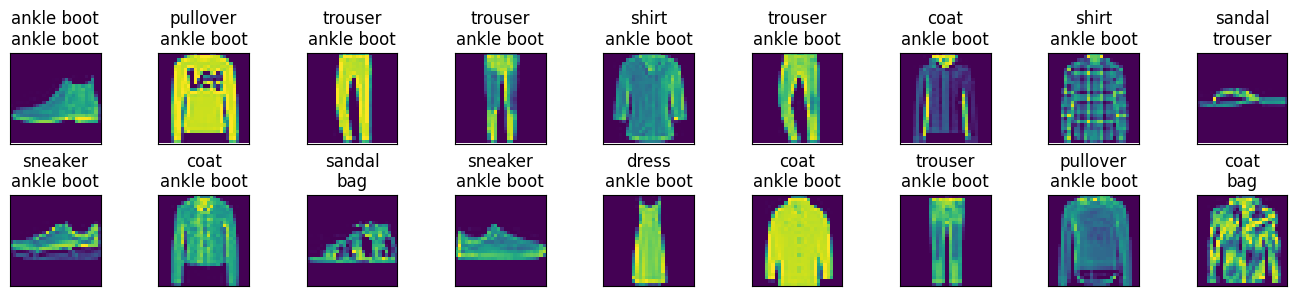

In [ ]:
# test after train
test_loss, test_acc = evaluate_accuracy(net, test_iter)
print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

# classifying images
def predict(net, test_iter, n=18):
    """Predict labels."""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 2, int(n/2), titles=titles[0:n])

predict(net, test_iter)

**MLP**

In [ ]:
# network
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

# reusing prev functions

batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size)
# train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, loss, num_epochs, optimizer)

# weight decay
wd = 0.001
optimizer = torch.optim.SGD(net.parameters(), weight_decay=wd, lr=lr)

# restart network
net.apply(init_weights)

# dropout layers
dropout1, dropout2 = 0.2, 0.3

net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # Add a dropout layer after the first fully connected layer
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # Add a dropout layer after the second fully connected layer
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

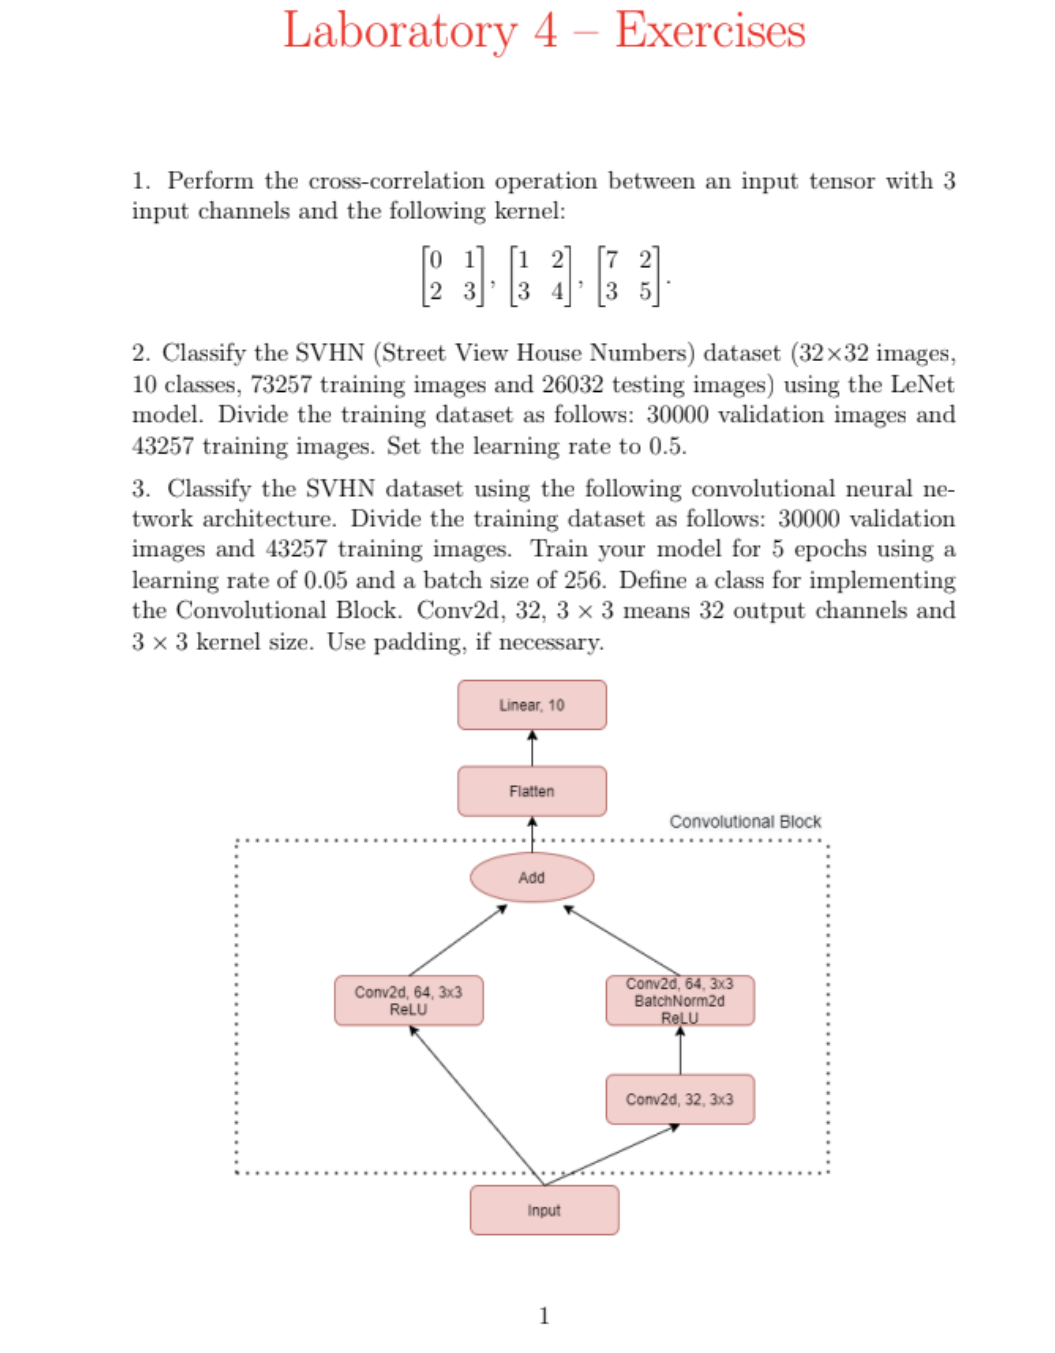

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [ ]:
# 1

import torch
import torch.nn.functional as F

# Define a simple 3-channel input tensor (shape: channels=3, height=3, width=3)
input_tensor = torch.tensor([
    [[1, 2, 3],
     [4, 5, 6],
     [7, 8, 9]],

    [[0, 1, 0],
     [1, 0, 1],
     [0, 1, 0]],

    [[1, 1, 1],
     [1, 1, 1],
     [1, 1, 1]]
], dtype=torch.float32)  # Shape: (3, 3, 3)

# Add a batch dimension (batch size = 1)
input_tensor = input_tensor.unsqueeze(0)  # Shape: (1, 3, 3, 3)

# Define a simple kernel (1 output channel, 3 input channels, kernel size 2x2)
kernel = torch.tensor([
    [[0, 1],
     [2, 3]],

    [[1, 2],
     [3, 4]],

    [[7, 2],
     [3, 5]]
], dtype=torch.float32).unsqueeze(0)  # Shape: (1, 3, 2, 2)

# Perform the cross-correlation using F.conv2d
output = F.conv2d(input_tensor, kernel, stride=1, padding=0)

# Squeeze the batch dimension for readability
output = output.squeeze()  # Shape: (2, 2)

print("Input Tensor:\n", input_tensor.squeeze())  # Remove batch dimension for display
print("Kernel:\n", kernel.squeeze())  # Remove output channels for display
print("Output Tensor:\n", output)


Input Tensor:
 tensor([[[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]],

        [[0., 1., 0.],
         [1., 0., 1.],
         [0., 1., 0.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])
Kernel:
 tensor([[[0., 1.],
         [2., 3.]],

        [[1., 2.],
         [3., 4.]],

        [[7., 2.],
         [3., 5.]]])
Output Tensor:
 tensor([[47., 53.],
        [65., 71.]])


In [ ]:
# 2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Define the LeNet model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load and preprocess the SVHN dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
valset = torchvision.datasets.SVHN(root='./data', split='extra', download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=256, shuffle=False, num_workers=2)

# Train the LeNet model
model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

100%|██████████| 182M/182M [00:06<00:00, 27.5MB/s]


100%|██████████| 1.33G/1.33G [01:21<00:00, 16.3MB/s]


[1, 100] loss: 2.272
[1, 200] loss: 2.238
[2, 100] loss: 2.233
[2, 200] loss: 2.230
[3, 100] loss: 2.215
[3, 200] loss: 2.189
[4, 100] loss: 1.812
[4, 200] loss: 1.354
[5, 100] loss: 0.849
[5, 200] loss: 0.744
Finished Training


In [ ]:
# 3
import torch.nn as nn

class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvolutionalBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

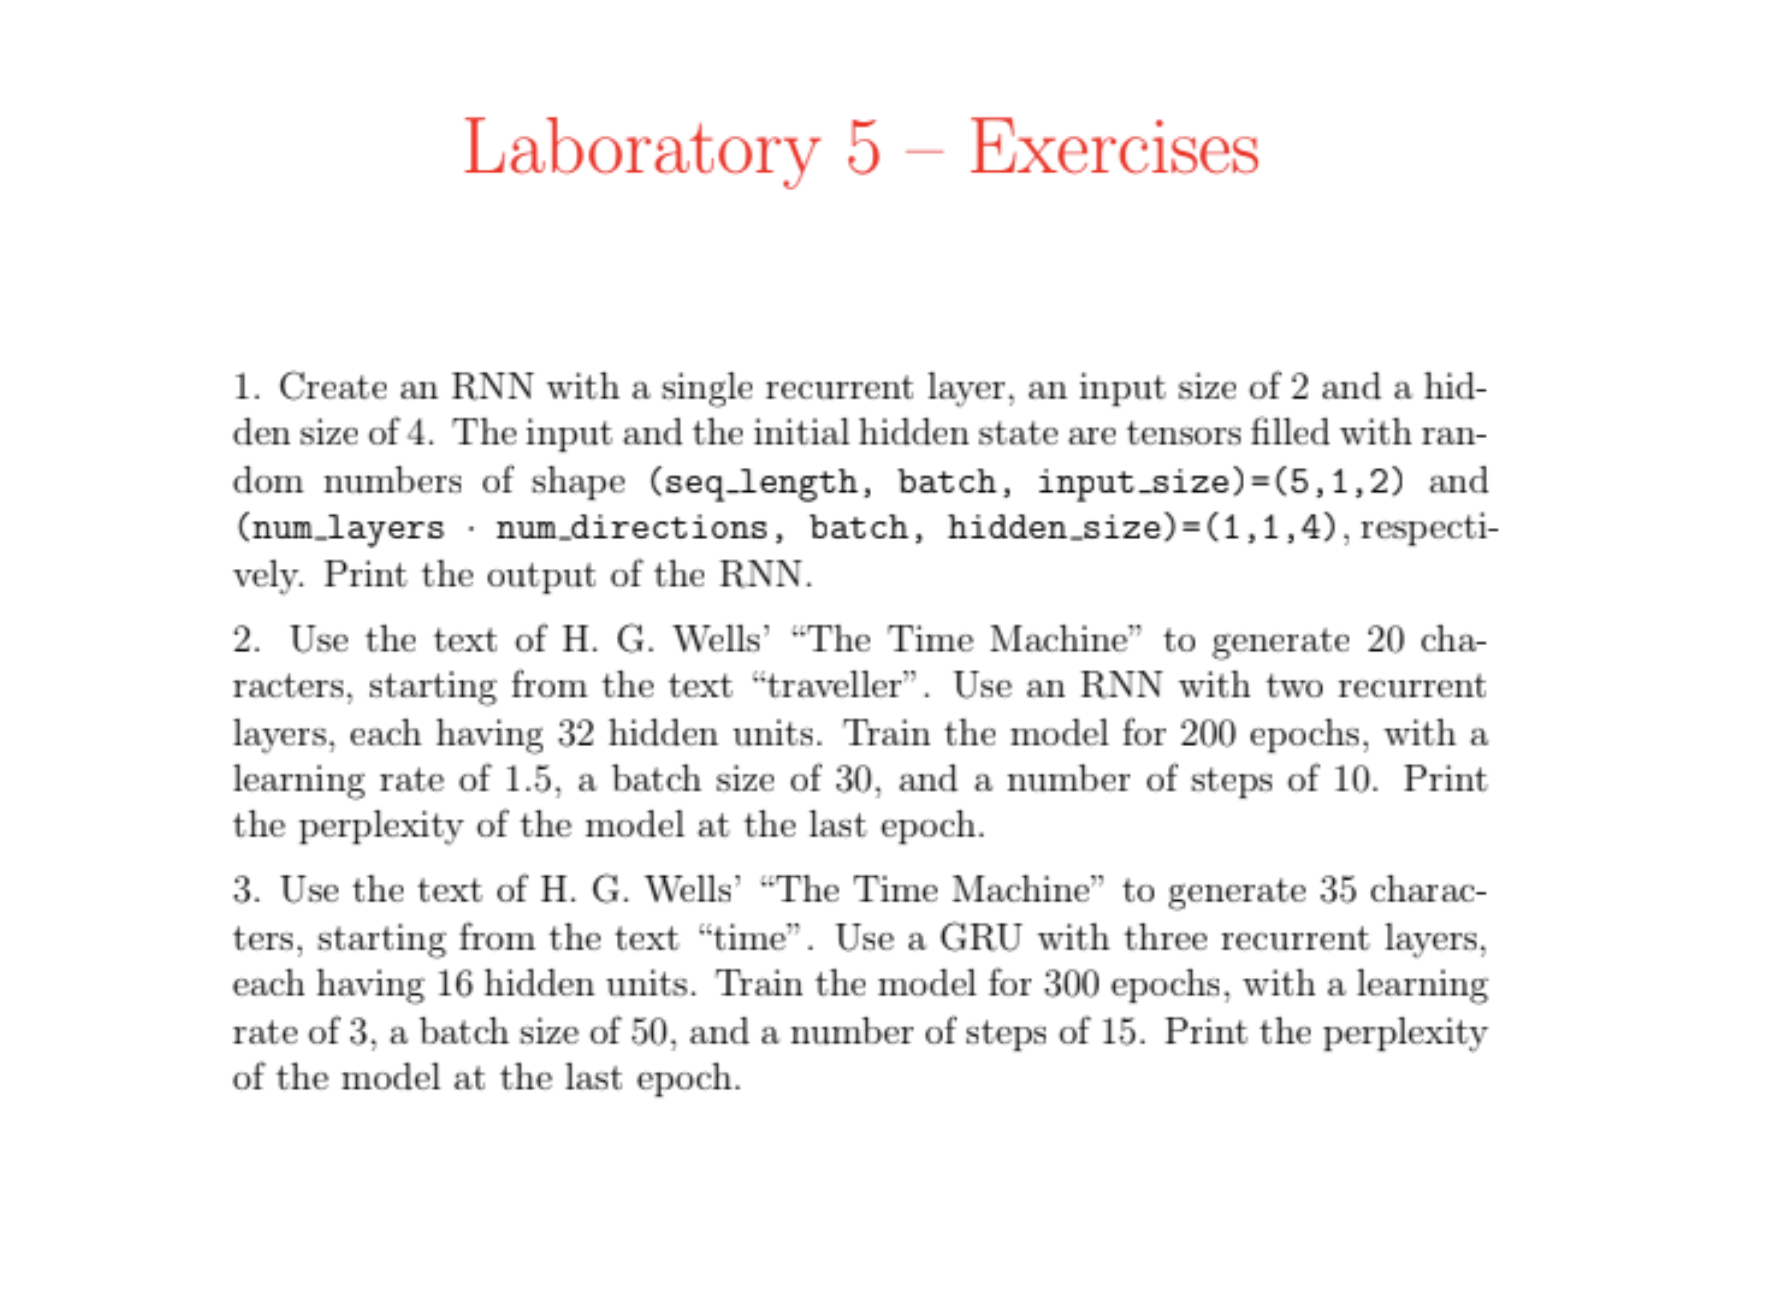

In [ ]:
import hashlib
import os
import requests
import re
import collections
import random
import torch
from torch import nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
import zipfile

torch.manual_seed(42);

In [ ]:
# Time Machine setup

def download(url, cache_dir=os.path.join('..', 'data')):
    """Download a file, return the local filename."""
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
        return fname
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(download('http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()

In [ ]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Token frequencies
        return self._token_freqs

def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

class SeqDataLoader:
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, max_tokens):
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return seq_data_iter_sequential(self.corpus, self.batch_size, self.num_steps)

In [ ]:
# Obtaining the data

def tokenize(lines, token='word'):
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

tokens = tokenize(lines)

vocab = Vocab(tokens)

def load_corpus_time_machine(max_tokens=-1):
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()

def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Generate a mini-batch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

def load_data_time_machine(batch_size, num_steps, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, max_tokens)
    return data_iter, data_iter.vocab

In [ ]:
# Making an RNN

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

state = torch.zeros((1, batch_size, num_hiddens))

class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        self.linear = nn.Linear(self.num_hiddens, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return  torch.zeros((self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                 device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((
                self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

def predict(prefix, num_preds, net, vocab, device):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [ ]:
# Making a prediction

def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

device = try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
predict('time traveller', 10, net, vocab, device)

# Gradient clipping

def grad_clipping(net, theta):
    """Clip the gradient."""
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [ ]:
# Training

def train_epoch(net, train_iter, loss, optimizer, device):
    """Train a net within one epoch."""
    state = None
    # Sum of training loss, no. of tokens
    total_loss = 0
    total_tokens = 0
    for X, Y in train_iter:
        if state is None:
            # Initialize `state` when it is the first iteration
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM`
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        optimizer.zero_grad()
        l.backward()
        grad_clipping(net, 1)
        optimizer.step()
        total_loss += float(l * y.numel())
        total_tokens += y.numel()
    return math.exp(total_loss / total_tokens)

def train(net, train_iter, vocab, lr, num_epochs, device):
    """Train a model."""
    loss = nn.CrossEntropyLoss()
    perplexities = []
    # Initialize
    optimizer = torch.optim.SGD(net.parameters(), lr)
    # Train and predict
    for epoch in range(num_epochs):
        ppl = train_epoch(
            net, train_iter, loss, optimizer, device)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller', 50, net, vocab, device))
            perplexities.append(ppl)
    print(f'perplexity {ppl:.1f}, device {str(device)}')
    print(predict('time traveller', 50, net, vocab, device))
    print(predict('traveller', 50, net, vocab, device))

    return perplexities

num_epochs, lr = 500, 1
perplexities = train(net, train_iter, vocab, lr, num_epochs, device) #1 min

time traveller of cun sand theilithe nsy hended nove ligiteonlan
time travellerit souglitilbughins ait the psain to time atont li
time travellerit s against reason said fferes so uxurd insail as
time travellerit tougd butred there was begly novurad at wy han 
time travellerit s against reatonat in a daver and sithe dim tro
time traveller proce hal very chatrome time brcalt mackact aryee
time travellerit s against reavonas another at seventeen another
time traveller brt acand i bavk ab unotloz mat s ove ary caldond
time travelleryou dimensions of southe and aniso f lating of tol
time travellerit s against reason bure accablo then at apght cav
time traveller after the payse they dous you ne nof semwthe time
time traveller of camise trat llin thicg is ool thes themedscal 
time traveller aftonithe onghit flishave beps incured the pountr
time travellerit would be weichligbe ssace you combanksthallight
time traveller brcand furecous back to samd the persce tith anof
time travellerit s agains

In [ ]:
# Exercise 1

import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=4, num_layers=1, batch_size=1, num_directions=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=(num_directions > 1))
        self.hidden_size = hidden_size * num_directions

    def forward(self, x):
        out, hidden = self.rnn(x)
        return out

model = RNNModel()
input_tensor = torch.randn(1, 5, 2)  # (batch_size, sequence_length, input_size)
output = model(input_tensor)
print(output)


tensor([[[-0.3424,  0.7563, -0.3879, -0.6091],
         [-0.4740,  0.6112, -0.7163, -0.7489],
         [ 0.6230, -0.3371, -0.1285,  0.3768],
         [ 0.8411, -0.2116,  0.7701,  0.8404],
         [ 0.7237,  0.0494,  0.7346,  0.8338]]], grad_fn=<TransposeBackward1>)


In [ ]:
# Perplexity Plotting
def plot_perplexity(perplexities):
    epochs = range(10, len(perplexities * 10) + 1, 10)
    plt.plot(epochs, perplexities, 'b', label='Train perplexity')
    plt.title('Training perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.show()

In [ ]:
# General Example  - GRU/LSTM

vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()
num_epochs, lr = 500, 1

num_inputs = vocab_size
gru_layer = nn.LSTM(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
perplexities = train(model, train_iter, vocab, lr, num_epochs, device) #4 min

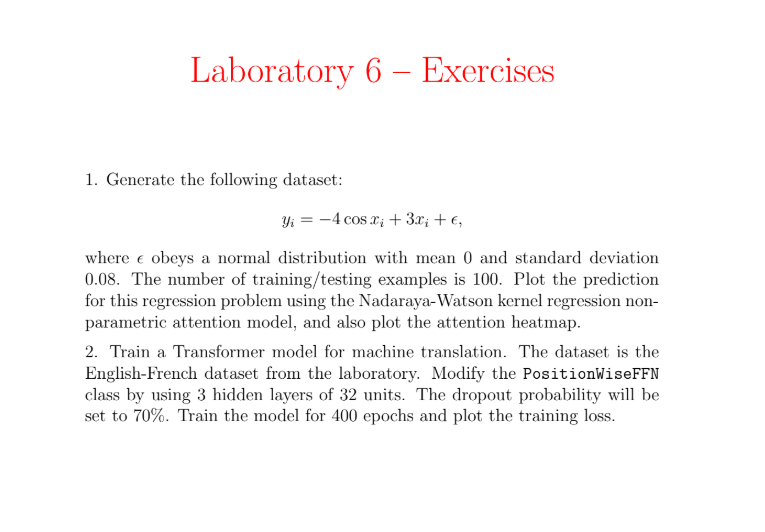

In [40]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import os
import requests
import zipfile
import collections

torch.manual_seed(42);

def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

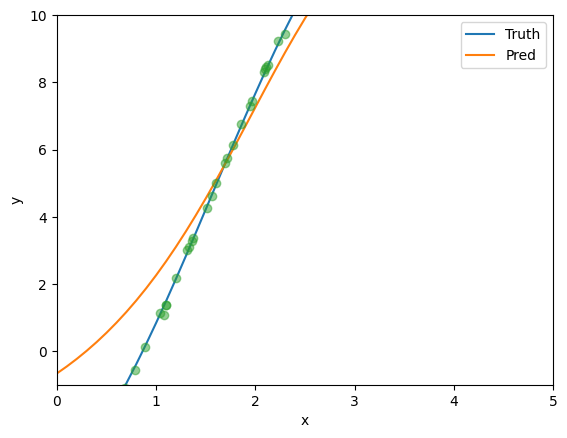

In [ ]:
# Exercise 1

n_train = 100  # No. of training examples
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # Training inputs

def f(x):
    return -4 * torch.cos(x) + 3 * x

y_train = f(x_train) + torch.normal(0.0, 0.08, (n_train,))  # Training outputs
x_test = torch.arange(0, 5, 0.1)  # Testing examples
y_truth = f(x_test)  # Ground-truth outputs for the testing examples
n_test = len(x_test)  # No. of testing examples
n_test

def plot_kernel_reg(y_hat):
    plt.plot(x_test, y_truth, label='Truth')
    plt.plot(x_test, y_hat, label='Pred')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([0, 5])
    plt.ylim([-1, 10])
    plt.legend()
    plt.plot(x_train, y_train, 'o', alpha=0.5);

# Shape of `X_repeat` is: (`n_test`, `n_train`), where each row contains the
# same testing inputs (i.e., same queries)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# Note that `x_train` contains the keys. Shape of `attention_weights` is:
# (`n_test`, `n_train`), where each row contains attention weights to be
# assigned among the values (`y_train`), given each query
attention_weights = F.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# Each element of `y_hat` is a weighted average of values, where weights are
# attention weights
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

In [42]:
# Exercise 2

class PositionWiseFFN(nn.Module):
    """Position-wise feed-forward network."""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_hiddens)
        self.dense3 = nn.Linear(ffn_num_hiddens, ffn_num_hiddens)
        self.dense4 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.7)

    def forward(self, X):
        x = self.dense1(X)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.dense3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.dense4(x)
        return x

embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, try_gpu()

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_loss_all = train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device) #2 min

NameError: name 'load_data_nmt' is not defined